In [1]:
import numpy as np
import netCDF4

from scipy import (special, signal, ndimage)
from scipy.ndimage import gaussian_filter

from ipywidgets import (interact)

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cartopy.crs as ccrs

plt.rcParams['figure.figsize'] = (25, 10)

import os
from pathlib import Path

In [2]:
from box import Box, DataSet
from units import unit
from plotting import (plot_mollweide, plot_orthographic_np, plot_plate_carree, earth_plot)

# Settings

In [86]:
data_folder = Path("/mnt/Knolselderij/bulk/Abrupt/")

sigma_d = unit('200 km')
sigma_t = unit('10 year')
sobel_weights = [1 * sigma_t, 1 * sigma_d, 1 * sigma_d]

data_set = DataSet(
    path=data_folder,
    # model='HadGEM2-ES',
    # variable='mrso',
    model = 'MPI-ESM-LR',
    variable = 'tas',
    scenario='rcp85',
    realization='r1i1p1'
)

data_set.load()

## Load the data

Next we define a `box`. The box contains all information on the geometry of the data. It loads the lattitudes and longitudes of the grid points from the NetCDF file and computes quantities like resolution.

In [87]:
from datetime import date, timedelta

box = data_set.box

print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*box.resolution))
for t in box.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

dt = box.time[1:] - box.time[:-1]
print("time steps: max", dt.max(), "min", dt.min())

(0.0833314 year, 207.379 km, 208.49 km) per pixel
2006-01-16, 2006-02-15, 2006-03-16,  ...
time steps: max 31.0 min 29.5


The ``Box`` class has the nice feature that you can select slices from it, and the information will adapt. The data we loaded contains monthly snapshots. If we select one snapshot in twelve, we obtain yearly data for that month. The ``Box`` class stores the axis grid points internally and slices the time axis accordingly.

In [88]:
yearly = box[::12]
print("({:.6~P}, {:.6~P}, {:.6~P}) per pixel".format(*yearly.resolution))
for t in yearly.time[:3]:
    print(box.date(t), end=', ')
print(" ...")

(0.999981 year, 207.379 km, 208.49 km) per pixel
2006-01-16, 2007-01-16, 2008-01-16,  ...


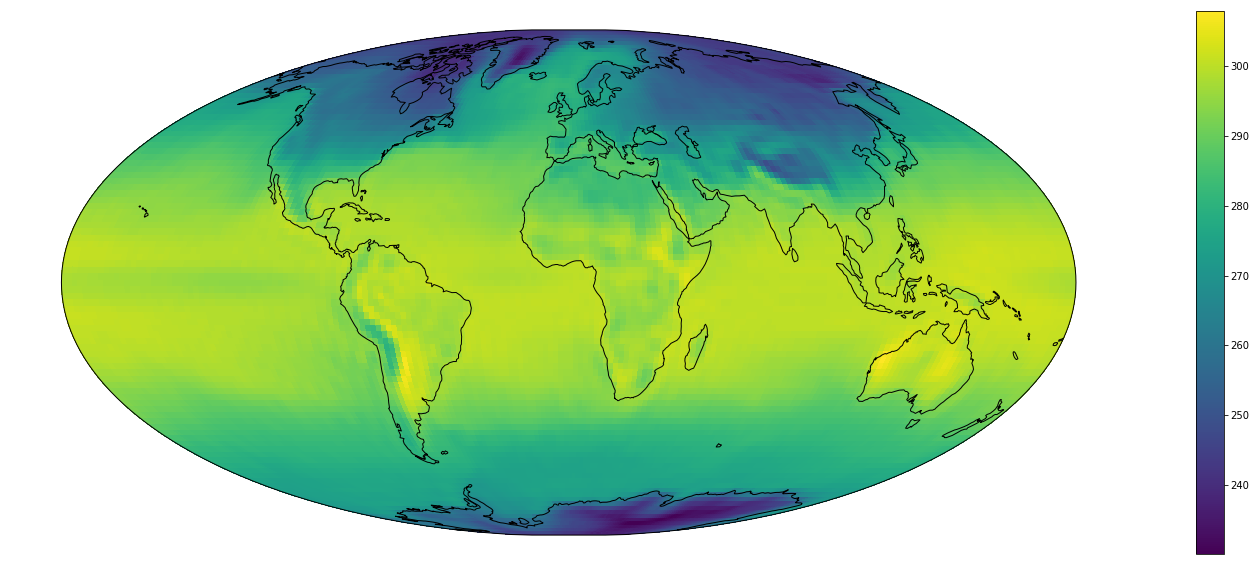

In [89]:
plot_mollweide(box, data_set.data[0])

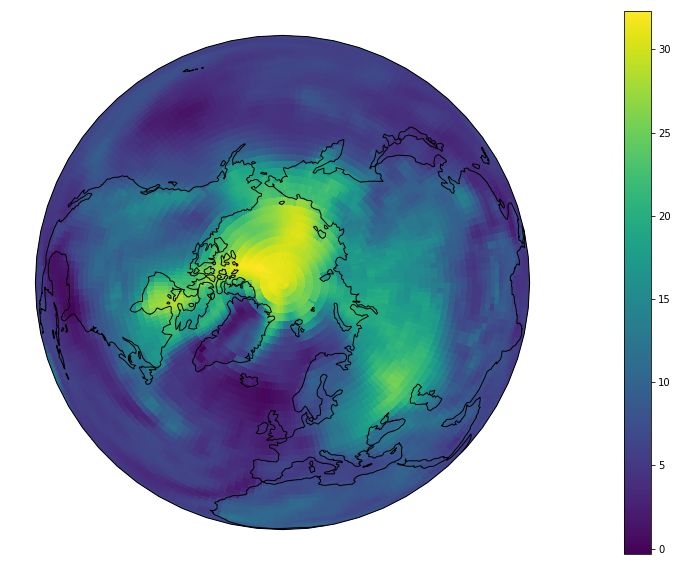

In [90]:
plot_orthographic_np(box, data_set.data[150*12] - data_set.data[0])

## Canny edges

The Canny edge detector consists of four stages:

* Smoothing
* Differentiating (Sobel operator)
* Non-maximum suppression
* Hysteresis thresholding

The first two of these stages are sensitive to the geometry of the information. How data is smoothed or differentiated is influenced by the spherical projection of our data. In this method we assume a Plate-Carree projection, where lattitudes and longitudes are mapped to a 1:2 rectangle with equal number of degrees per pixel everywhere. We may test this assumption on our ``box`` object.

In [91]:
box.rectangular

True

### Smoothing

Smoothing in the lattitudinal direction (N-S) is not affected by the projection; distances do not vary since the circles of equal longitude are all greater circles on the sphere. We apply a Gaussian filter where we reflect data in the lattitudinal and time directions and wrap in the longitudinal direction. Next, to filter in the longitudinal direction, we need to use a different filter width for each lattitude.

In [92]:
data = data_set.data[2::12]
yearly_box = box[2::12]

smooth_data = yearly_box.gaussian_filter(data, [sigma_t, sigma_d, sigma_d])

### Sobel filtering
The Sobel filter has the same problem as the Gaussian filter, but the solution is easier. We just correct for the magnitude of the Sobel response by multiplying the longitudinal component by the cosine of the latitude.

In [93]:
sb = yearly_box.sobel_filter(smooth_data, weight=sobel_weights)

### Determine proper hysteresis settings

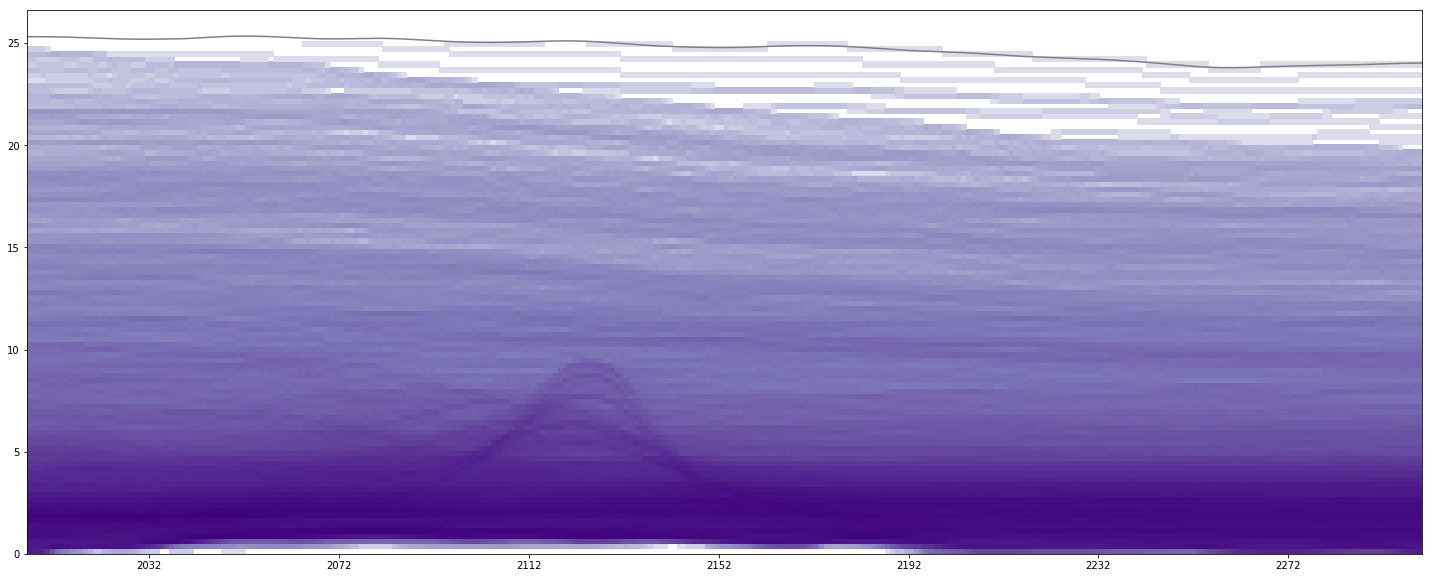

In [94]:
signal = 1.0 / sb[3]

# flatten sobel signal
n_years = yearly_box.shape[0]
signal_flat = signal.reshape([n_years, -1])

# create bins for histograms
n_bins = 100
bins = np.linspace(signal.min(), signal.max(), n_bins+1)

# generate histogram for each time step
hist = np.zeros(shape=(n_years, n_bins))
for t in range(n_years):
    h, _ = np.histogram(signal_flat[t], bins=bins)
    hist[t, :] = h

# plot
plt.pcolormesh(yearly_box.dates, bins[:-1], hist.T,
               norm=colors.LogNorm(vmin=0.1, vmax=hist.max()),
               cmap='Purples')
plt.plot(yearly_box.dates, signal_flat.max(axis=1), '-', c='gray')
plt.show()

In [95]:
from hyper_canny import cp_edge_thinning, cp_double_threshold

In [96]:
dat = sb.transpose([3,2,1,0]).copy()
mask = cp_edge_thinning(dat)
thinned = mask.transpose([2, 1, 0])

In [97]:
edges = cp_double_threshold(data=dat, mask=mask, a=1/10, b=1/6)
m = edges.transpose([2, 1, 0])

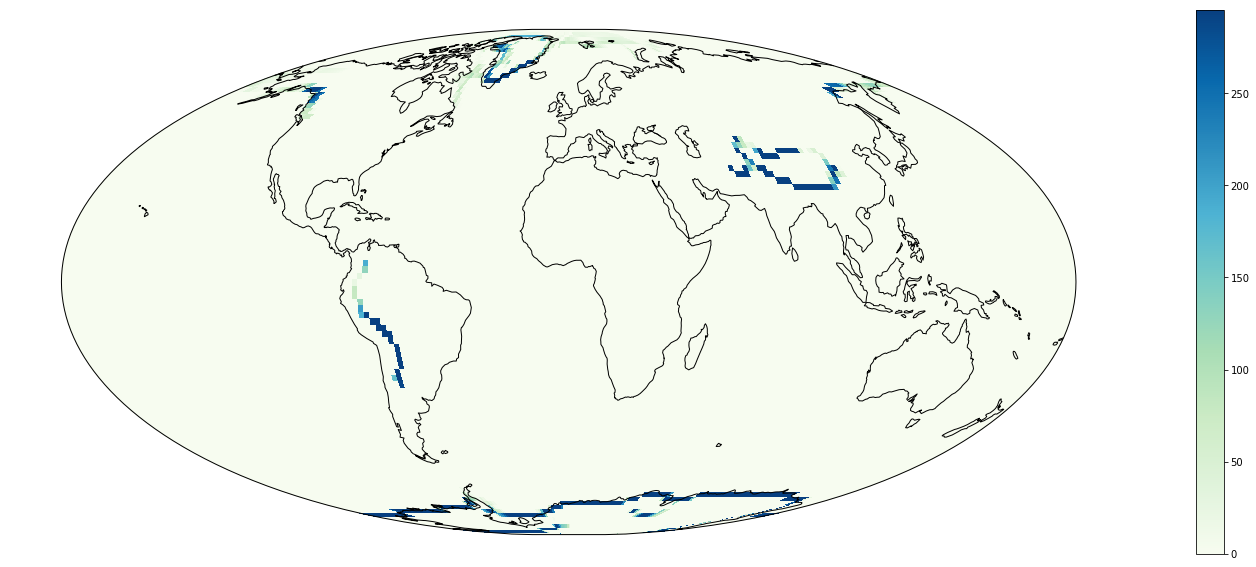

In [98]:
plot_mollweide(yearly_box, m.sum(axis=0), cmap='GnBu')

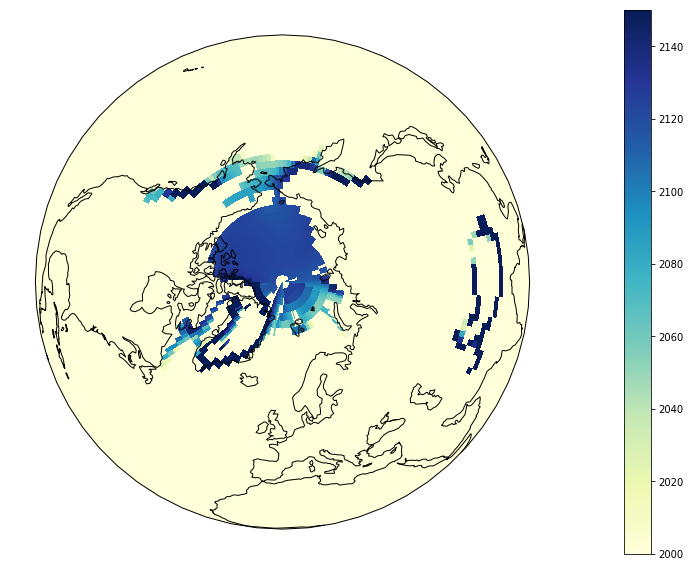

In [99]:
years = np.array([d.year for d in yearly_box.dates])
plot_orthographic_np(yearly_box, (years[:,None,None]*m).max(axis=0),  cmap='YlGnBu', vmin=2000, vmax=2150)

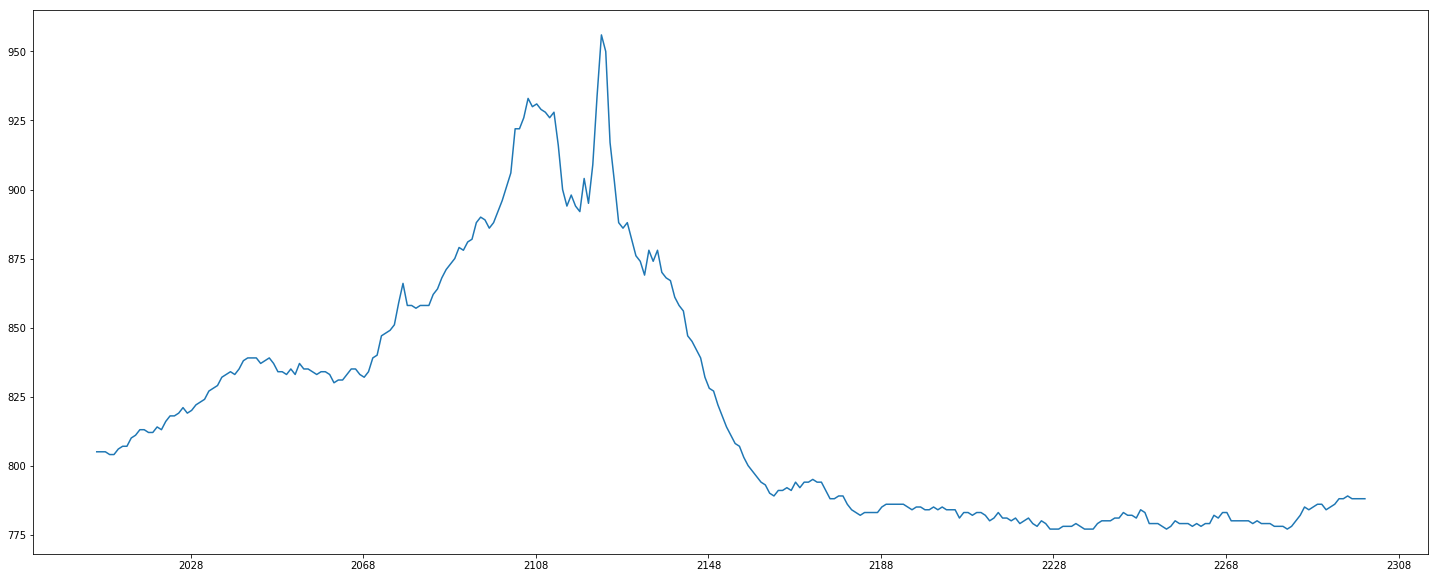

In [85]:
plt.plot(yearly_box.dates, m.sum(axis=1).sum(axis=1))
plt.show()

# PI Control

In [8]:
control_set = DataSet(
    path=data_folder, model='MPI-ESM-LR', variable='tas',
    scenario='piControl', realization='r1i1p1')
control_set.load()

In [37]:
control_data = control_set.data[2::12]
yearly_box = control_set.box[2::12]

smooth_control_data = yearly_box.gaussian_filter(control_data, [sigma_t, sigma_d, sigma_d])
sbc = yearly_box.sobel_filter(smooth_control_data, weight=sobel_weights)

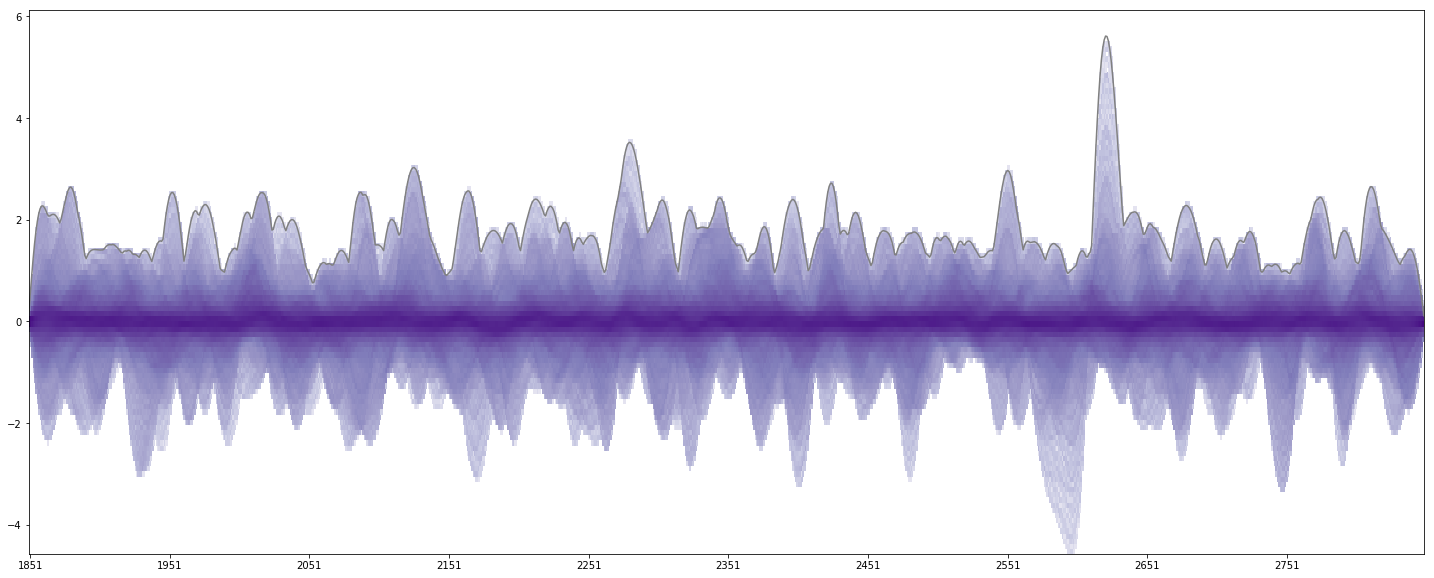

In [38]:
signal = sbc[0]/sbc[3,:,:,:]

# flatten sobel signal
n_years = yearly_box.shape[0]
signal_flat = signal.reshape([n_years, -1])

# create bins for histograms
n_bins = 100
bins = np.linspace(signal.min(), signal.max(), n_bins+1)

# generate histogram for each time step
hist = np.zeros(shape=(n_years, n_bins))
for t in range(n_years):
    h, _ = np.histogram(signal_flat[t], bins=bins)
    hist[t, :] = h

# plot
plt.pcolormesh(yearly_box.dates, bins[:-1], hist.T,
               norm=colors.LogNorm(vmin=0.1, vmax=hist.max()),
               cmap='Purples')
plt.plot(yearly_box.dates, signal_flat.max(axis=1), '-', c='gray')
plt.show()

In [11]:
# std = np.sqrt((sbc[0]/sbc[3]).var(axis=0) + (sb[1]/sb[3]).var(axis=0) + (sb[2]/sb[3]).var(axis=0))
std0 = (sbc[0] / sbc[3]).std(axis=0)
std1 = (sbc[1] / sbc[3]).std(axis=0)
std2 = (sbc[2] / sbc[3]).std(axis=0)

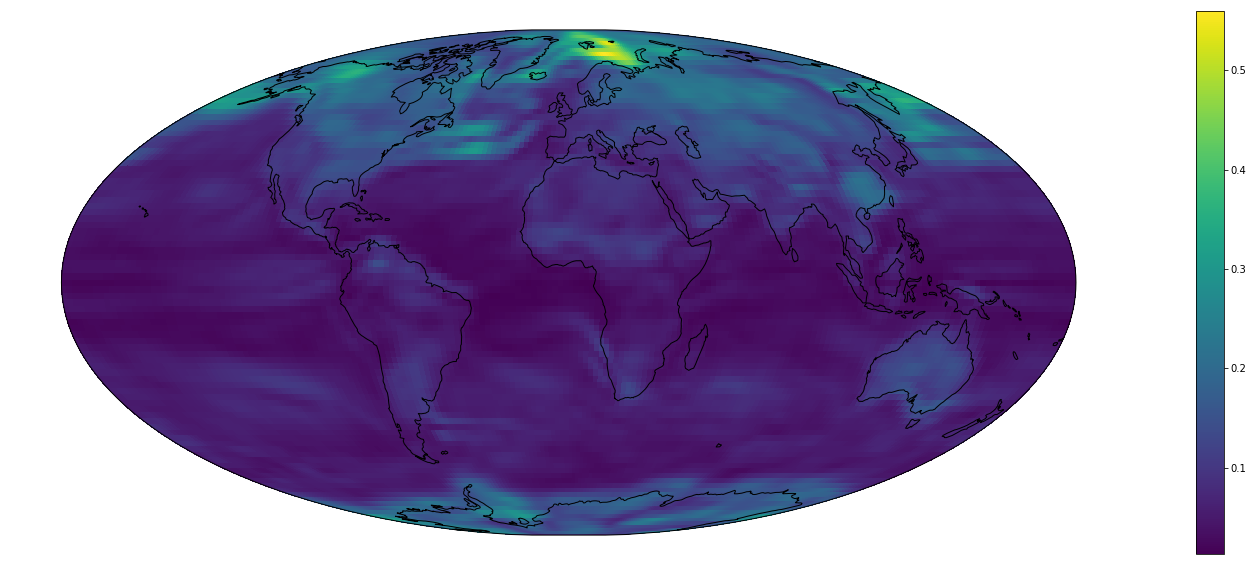

In [258]:
plot_mollweide(box, std1)

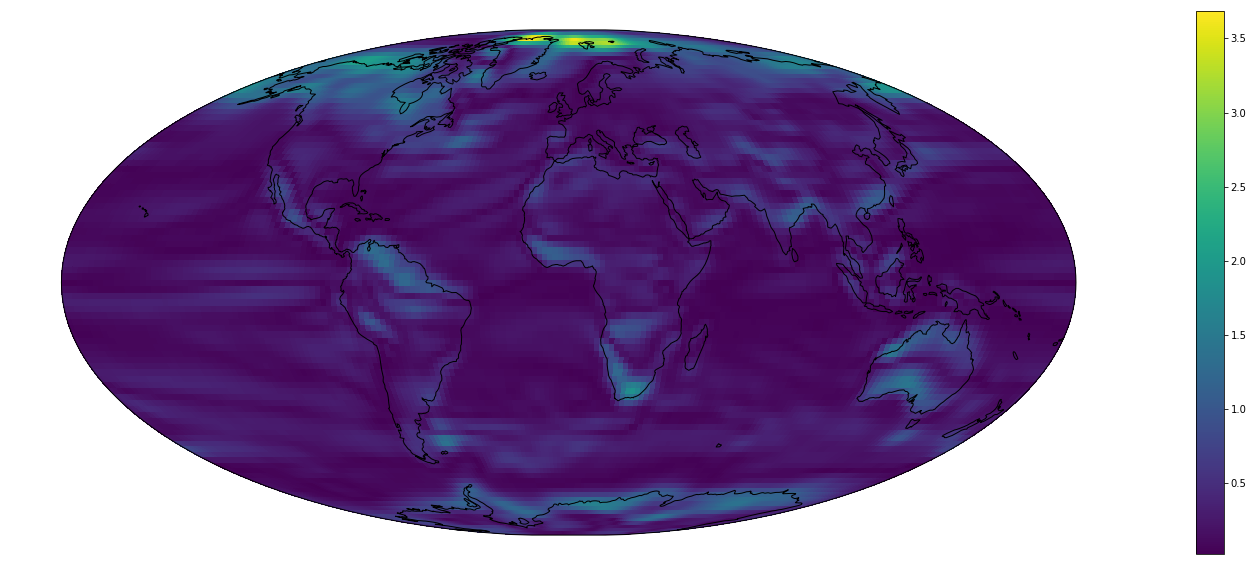

In [259]:
plot_mollweide(box, (sb[1]/sb[3]).std(axis=0))

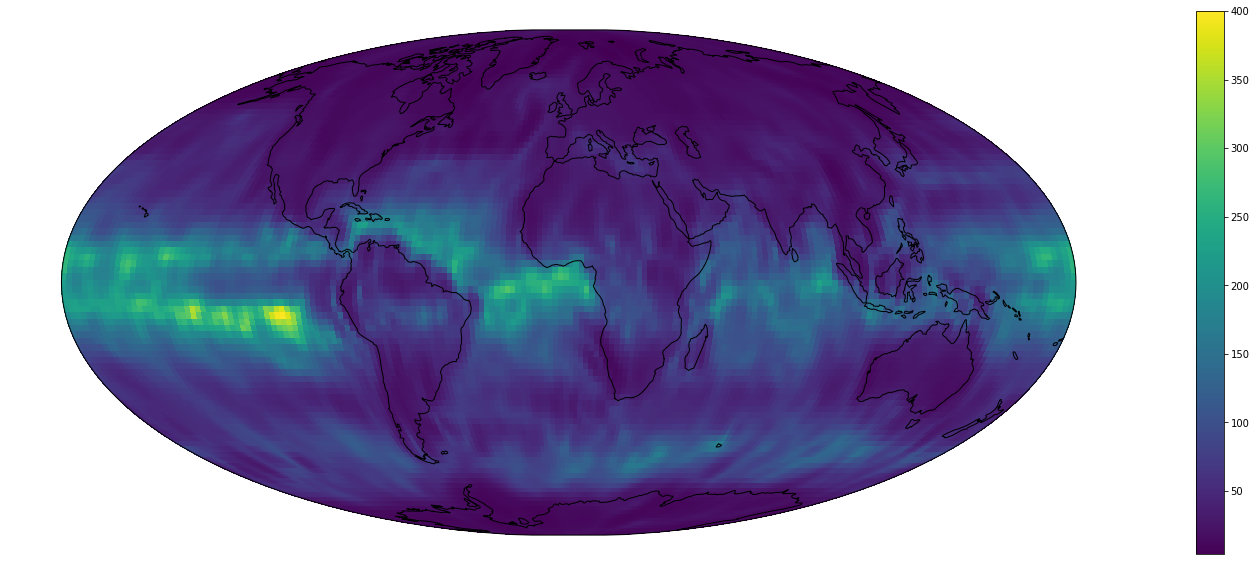

In [264]:
plot_mollweide(box, (sb[2]/sb[3]).std() / std2)